In [1]:
# ============================================================================
# CELL 1: Install Required Libraries
# ============================================================================
"""
Run this cell first to install all required packages
"""

# !pip install pandas numpy scikit-learn xgboost lightgbm catboost matplotlib seaborn

print("✓ All libraries installed successfully!")



✓ All libraries installed successfully!


In [2]:

# ============================================================================
# CELL 2: Import Libraries
# ============================================================================
"""
Import all necessary libraries for the IDS framework
"""

import pandas as pd
import numpy as np
import time
import warnings
import pickle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, matthews_corrcoef,
                             confusion_matrix, classification_report)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


✓ All libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 1.26.4


In [3]:
# ============================================================================
# CELL 3: Data Loading Functions
# ============================================================================
"""
Functions to load CIC2017 and CIC2023 datasets with proper paths
"""

import os
from pathlib import Path
import glob

# Define base paths
BASE_DIR = Path(r"c:\Users\Ayaan\Downloads\Compressed\cnet\Base Implementation")
CIC2017_DIR = BASE_DIR / "data" / "CIC2017"
CIC2023_DIR = BASE_DIR / "data" / "CIC2023"

def load_cic2017_dataset(combine=True):
    """
    Load CIC2017 dataset from multiple CSV files.
    
    Parameters:
    -----------
    combine : bool, default=True
        If True, combines all CSV files into a single DataFrame.
        If False, returns a list of DataFrames.
    
    Returns:
    --------
    pd.DataFrame or list of pd.DataFrame
        Combined dataset or list of individual datasets
    """
    print("=" * 80)
    print("Loading CIC2017 Dataset")
    print("=" * 80)
    
    # Get all CSV files
    csv_files = sorted(glob.glob(str(CIC2017_DIR / "*.csv")))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {CIC2017_DIR}")
    
    print(f"Found {len(csv_files)} CSV files:")
    for file in csv_files:
        file_size = os.path.getsize(file) / (1024 * 1024)  # Size in MB
        print(f"  - {Path(file).name} ({file_size:.2f} MB)")
    
    dataframes = []
    total_rows = 0
    
    for file in csv_files:
        print(f"\nLoading {Path(file).name}...", end=" ")
        df = pd.read_csv(file, encoding='utf-8', low_memory=False)
        
        # Clean column names (remove leading/trailing spaces)
        df.columns = df.columns.str.strip()
        
        rows = len(df)
        total_rows += rows
        print(f"✓ ({rows:,} rows)")
        
        dataframes.append(df)
    
    if combine:
        print(f"\nCombining all datasets...", end=" ")
        combined_df = pd.concat(dataframes, ignore_index=True)
        print(f"✓")
        print(f"\nTotal rows: {total_rows:,}")
        print(f"Total columns: {len(combined_df.columns)}")
        print(f"Target column: 'Label'")
        print(f"Unique labels: {combined_df['Label'].nunique()}")
        print(f"\nLabel distribution:")
        print(combined_df['Label'].value_counts())
        return combined_df
    else:
        print(f"\nTotal rows across all files: {total_rows:,}")
        return dataframes


def load_cic2023_dataset(split='train'):
    """
    Load CIC2023 dataset (train, validation, or test split).
    
    Parameters:
    -----------
    split : str, default='train'
        Which split to load: 'train', 'validation', or 'test'
    
    Returns:
    --------
    pd.DataFrame
        The requested dataset split
    """
    print("=" * 80)
    print(f"Loading CIC2023 Dataset - {split.upper()} Split")
    print("=" * 80)
    
    # Construct file path
    split_dir = CIC2023_DIR / split
    csv_file = split_dir / f"{split}.csv"
    
    if not csv_file.exists():
        raise FileNotFoundError(f"File not found: {csv_file}")
    
    file_size = os.path.getsize(csv_file) / (1024 * 1024)  # Size in MB
    print(f"Loading {csv_file.name} ({file_size:.2f} MB)...", end=" ")
    
    df = pd.read_csv(csv_file, encoding='utf-8', low_memory=False)
    
    # Clean column names
    df.columns = df.columns.str.strip()
    
    print(f"✓")
    print(f"\nRows: {len(df):,}")
    print(f"Columns: {len(df.columns)}")
    print(f"Target column: 'label'")
    print(f"Unique labels: {df['label'].nunique()}")
    print(f"\nLabel distribution:")
    print(df['label'].value_counts())
    
    return df


def load_cic2023_all_splits():
    """
    Load all CIC2023 splits (train, validation, test).
    
    Returns:
    --------
    tuple of pd.DataFrame
        (train_df, val_df, test_df)
    """
    train_df = load_cic2023_dataset('train')
    val_df = load_cic2023_dataset('validation')
    test_df = load_cic2023_dataset('test')
    
    print("\n" + "=" * 80)
    print("All CIC2023 splits loaded successfully!")
    print("=" * 80)
    
    return train_df, val_df, test_df


def get_dataset_info():
    """
    Display information about available datasets.
    """
    print("=" * 80)
    print("AVAILABLE DATASETS")
    print("=" * 80)
    
    print("\n1. CIC2017 Dataset")
    print(f"   Location: {CIC2017_DIR}")
    print("   Files:")
    for file in sorted(glob.glob(str(CIC2017_DIR / "*.csv"))):
        file_size = os.path.getsize(file) / (1024 * 1024)
        print(f"     - {Path(file).name} ({file_size:.2f} MB)")
    
    print("\n2. CIC2023 Dataset")
    print(f"   Location: {CIC2023_DIR}")
    print("   Splits:")
    for split in ['train', 'validation', 'test']:
        split_file = CIC2023_DIR / split / f"{split}.csv"
        if split_file.exists():
            file_size = os.path.getsize(split_file) / (1024 * 1024)
            print(f"     - {split}.csv ({file_size:.2f} MB)")
    
    print("\n" + "=" * 80)


# Display dataset information
get_dataset_info()

print("\n✓ Data loading functions defined successfully!")
print("\nUsage Examples:")
print("  # Load CIC2017 (combined)")
print("  df_2017 = load_cic2017_dataset(combine=True)")
print("\n  # Load CIC2023 train split")
print("  df_2023_train = load_cic2023_dataset('train')")
print("\n  # Load all CIC2023 splits")
print("  train_df, val_df, test_df = load_cic2023_all_splits()")


AVAILABLE DATASETS

1. CIC2017 Dataset
   Location: c:\Users\Ayaan\Downloads\Compressed\cnet\Base Implementation\data\CIC2017
   Files:
     - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv (73.55 MB)
     - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (73.34 MB)
     - Friday-WorkingHours-Morning.pcap_ISCX.csv (55.62 MB)
     - Monday-WorkingHours.pcap_ISCX.csv (168.73 MB)
     - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (79.25 MB)
     - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (49.61 MB)
     - Tuesday-WorkingHours.pcap_ISCX.csv (128.82 MB)
     - Wednesday-workingHours.pcap_ISCX.csv (214.74 MB)

2. CIC2023 Dataset
   Location: c:\Users\Ayaan\Downloads\Compressed\cnet\Base Implementation\data\CIC2023
   Splits:
     - train.csv (1548.24 MB)
     - validation.csv (331.80 MB)
     - test.csv (331.84 MB)


✓ Data loading functions defined successfully!

Usage Examples:
  # Load CIC2017 (combined)
  df_2017 = load_cic2017_dataset(combine=True)



In [4]:


# ============================================================================
# CELL 3: Define IDSFramework Class
# ============================================================================
"""
Main framework class for IoT Intrusion Detection System
Based on Adewole et al. (2025) - Sensors Journal
"""

class IDSFramework:
    """Main framework for IoT Intrusion Detection System"""
    
    def __init__(self, dataset_name='CIC-IDS2017'):
        self.dataset_name = dataset_name
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.feature_names = None
        self.class_names = None
        self.scaler = MinMaxScaler()
        self.label_encoder = LabelEncoder()
        self.models = {}
        self.results = {}
        
    def load_and_prepare_data(self, file_path, task='binary'):
        """
        Load and prepare dataset
        
        Args:
            file_path: Path to CSV file
            task: 'binary' or 'multiclass'
        """
        print(f"\n{'='*60}")
        print(f"Loading {self.dataset_name} dataset...")
        print(f"{'='*60}")
        
        # Load data
        df = pd.read_csv(file_path)
        print(f"Initial shape: {df.shape}")
        
        # Data cleaning
        df = self._clean_data(df)
        print(f"After cleaning: {df.shape}")
        
        # Prepare features and labels
        X, y = self._prepare_features_labels(df, task)
        
        # Split data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        print(f"Training set: {self.X_train.shape}")
        print(f"Test set: {self.X_test.shape}")
        print(f"\nClass distribution in training set:")
        print(pd.Series(self.y_train).value_counts())
        
        return self
        
    def _clean_data(self, df):
        """Clean the dataset"""
        
        if self.dataset_name == 'CIC-IDS2017':
            # Remove duplicate column
            if 'Fwd Header Length.1' in df.columns:
                df = df.drop('Fwd Header Length.1', axis=1)
            
            # Handle infinity values
            df = df.replace([np.inf, -np.inf], np.nan)
            
            # Remove duplicates
            print(f"Duplicates found: {df.duplicated().sum()}")
            df = df.drop_duplicates()
            
        elif self.dataset_name == 'CICIoT2023':
            # Remove duplicates (dataset has ~53% duplicates)
            print(f"Duplicates found: {df.duplicated().sum()}")
            df = df.drop_duplicates()
            
            # Handle infinity values
            df = df.replace([np.inf, -np.inf], np.nan)
        
        # Handle missing values with KNN imputation
        if df.isnull().sum().sum() > 0:
            print(f"Missing values found: {df.isnull().sum().sum()}")
            
            # Separate label column
            label_col = df.columns[-1]
            labels = df[label_col]
            features = df.drop(label_col, axis=1)
            
            # Impute only numeric columns
            numeric_cols = features.select_dtypes(include=[np.number]).columns
            
            if len(numeric_cols) > 0:
                imputer = KNNImputer(n_neighbors=2)
                features[numeric_cols] = imputer.fit_transform(features[numeric_cols])
            
            df = pd.concat([features, labels], axis=1)
        
        return df
    
    def _prepare_features_labels(self, df, task):
        """Prepare features and labels"""
        
        # Get label column (usually last column)
        label_col = df.columns[-1]
        
        # Separate features and labels
        X = df.drop(label_col, axis=1)
        y = df[label_col]
        
        # Store feature names
        self.feature_names = X.columns.tolist()
        
        # Encode labels
        if task == 'binary':
            # Binary: 0 for benign, 1 for attack
            y = y.apply(lambda x: 0 if 'BENIGN' in str(x).upper() else 1)
            self.class_names = ['Benign', 'Attack']
        else:
            # Multi-class: encode all attack types
            y = self.label_encoder.fit_transform(y)
            self.class_names = self.label_encoder.classes_.tolist()
        
        # Normalize features
        X = pd.DataFrame(
            self.scaler.fit_transform(X),
            columns=X.columns
        )
        
        return X, y
    
    def initialize_models(self):
        """Initialize ensemble models"""
        
        print(f"\n{'='*60}")
        print("Initializing Ensemble Models...")
        print(f"{'='*60}")
        
        self.models = {
            'Random Forest': RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            ),
            'AdaBoost': AdaBoostClassifier(
                n_estimators=100,
                learning_rate=1.0,
                random_state=42
            ),
            'XGBoost': XGBClassifier(
                n_estimators=100,
                max_depth=6,
                subsample=0.5,
                eta=0.3,
                random_state=42,
                n_jobs=-1,
                eval_metric='logloss'
            ),
            'LightGBM': LGBMClassifier(
                n_estimators=100,
                random_state=42,
                n_jobs=-1,
                verbose=-1
            ),
            'CatBoost': CatBoostClassifier(
                iterations=100,
                random_state=42,
                verbose=0
            )
        }
        
        print(f"Models initialized: {list(self.models.keys())}")
        return self
    
    def train_and_evaluate(self):
        """Train and evaluate all models"""
        
        print(f"\n{'='*60}")
        print("Training and Evaluating Models...")
        print(f"{'='*60}\n")
        
        for name, model in self.models.items():
            print(f"\nTraining {name}...")
            
            # Training
            start_time = time.time()
            model.fit(self.X_train, self.y_train)
            train_time = time.time() - start_time
            
            # Inference
            start_time = time.time()
            y_pred = model.predict(self.X_test)
            inference_time = time.time() - start_time
            
            # Probabilities for AUC-ROC
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(self.X_test)
            else:
                y_pred_proba = None
            
            # Calculate metrics
            metrics = self._calculate_metrics(y_pred, y_pred_proba)
            metrics['train_time'] = train_time
            metrics['inference_time'] = inference_time
            
            # Calculate error rates
            cm = confusion_matrix(self.y_test, y_pred)
            fpr, fnr = self._calculate_error_rates(cm)
            metrics['fpr'] = fpr
            metrics['fnr'] = fnr
            
            self.results[name] = metrics
            
            print(f"{name} - Accuracy: {metrics['accuracy']:.4f}, "
                  f"Train Time: {train_time:.2f}s, "
                  f"Inference Time: {inference_time:.2f}s")
        
        return self
    
    def _calculate_metrics(self, y_pred, y_pred_proba):
        """Calculate evaluation metrics"""
        
        metrics = {}
        
        # Basic metrics
        metrics['accuracy'] = accuracy_score(self.y_test, y_pred)
        
        # For multi-class, use weighted average
        avg_method = 'binary' if len(np.unique(self.y_test)) == 2 else 'weighted'
        
        metrics['precision'] = precision_score(self.y_test, y_pred, 
                                               average=avg_method, zero_division=0)
        metrics['recall'] = recall_score(self.y_test, y_pred, 
                                         average=avg_method, zero_division=0)
        metrics['f1_score'] = f1_score(self.y_test, y_pred, 
                                       average=avg_method, zero_division=0)
        metrics['mcc'] = matthews_corrcoef(self.y_test, y_pred)
        
        # AUC-ROC
        if y_pred_proba is not None:
            try:
                if len(np.unique(self.y_test)) == 2:
                    metrics['auc_roc'] = roc_auc_score(self.y_test, 
                                                       y_pred_proba[:, 1])
                else:
                    metrics['auc_roc'] = roc_auc_score(self.y_test, 
                                                       y_pred_proba, 
                                                       multi_class='ovr',
                                                       average='weighted')
            except:
                metrics['auc_roc'] = 0.0
        else:
            metrics['auc_roc'] = 0.0
        
        return metrics
    
    def _calculate_error_rates(self, cm):
        """Calculate FPR and FNR from confusion matrix"""
        
        if len(cm) == 2:
            # Binary classification
            tn, fp, fn, tp = cm.ravel()
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        else:
            # Multi-class: average across classes
            fpr_list = []
            fnr_list = []
            
            for i in range(len(cm)):
                tp = cm[i, i]
                fn = cm[i, :].sum() - tp
                fp = cm[:, i].sum() - tp
                tn = cm.sum() - tp - fn - fp
                
                fpr_i = fp / (fp + tn) if (fp + tn) > 0 else 0
                fnr_i = fn / (fn + tp) if (fn + tp) > 0 else 0
                
                fpr_list.append(fpr_i)
                fnr_list.append(fnr_i)
            
            fpr = np.mean(fpr_list)
            fnr = np.mean(fnr_list)
        
        return fpr, fnr
    
    def display_results(self):
        """Display results in table format"""
        
        print(f"\n{'='*60}")
        print(f"Results Summary - {self.dataset_name}")
        print(f"{'='*60}\n")
        
        results_df = pd.DataFrame(self.results).T
        results_df = results_df.round(4)
        
        print(results_df.to_string())
        
        # Find best model
        best_model = results_df['accuracy'].idxmax()
        print(f"\n{'='*60}")
        print(f"Best Model: {best_model}")
        print(f"Accuracy: {results_df.loc[best_model, 'accuracy']:.4f}")
        print(f"{'='*60}")
        
        return best_model, results_df
    
    def extract_rules(self, model_name='XGBoost', max_rules=10):
        """
        Extract rules from decision tree-based model
        Implementation of Algorithm 1 from the paper
        """
        
        print(f"\n{'='*60}")
        print(f"Extracting Rules from {model_name}")
        print(f"{'='*60}\n")
        
        model = self.models[model_name]
        rules = []
        
        # Get tree structure
        if model_name == 'Random Forest' or model_name == 'AdaBoost':
            if hasattr(model, 'estimators_'):
                tree = model.estimators_[0].tree_
                
                def recurse(node, path, tree_obj):
                    if tree_obj.feature[node] != -2:  # Not a leaf
                        feature_name = self.feature_names[tree_obj.feature[node]]
                        threshold = tree_obj.threshold[node]
                        
                        # Left path (<=)
                        left_path = path + [f"({feature_name} <= {threshold:.3f})"]
                        recurse(tree_obj.children_left[node], left_path, tree_obj)
                        
                        # Right path (>)
                        right_path = path + [f"({feature_name} > {threshold:.3f})"]
                        recurse(tree_obj.children_right[node], right_path, tree_obj)
                    else:
                        # Leaf node
                        value = tree_obj.value[node]
                        samples = tree_obj.n_node_samples[node]
                        
                        # Determine class and probability
                        class_idx = np.argmax(value[0])
                        class_name = self.class_names[class_idx]
                        proba = 100.0 * value[0][class_idx] / np.sum(value[0])
                        
                        rule = "if " + " and ".join(path)
                        rule += f" then class: {class_name} (proba: {proba:.2f}%) "
                        rule += f"| based on {samples} samples"
                        
                        rules.append({
                            'rule': rule,
                            'class': class_name,
                            'probability': proba,
                            'samples': samples
                        })
                
                recurse(0, [], tree)
                
        elif model_name == 'XGBoost':
            # For XGBoost, get feature importance
            feature_importance = model.feature_importances_
            top_features_idx = np.argsort(feature_importance)[-10:][::-1]
            
            print("Top 10 Important Features:")
            for idx in top_features_idx:
                print(f"  {self.feature_names[idx]}: {feature_importance[idx]:.4f}")
            
            # Simplified rule extraction for XGBoost
            rules.append({
                'rule': f"XGBoost model uses {len(self.feature_names)} features",
                'class': 'Multiple',
                'probability': 0.0,
                'samples': len(self.X_train)
            })
        
        # Sort by number of samples
        rules.sort(key=lambda x: x['samples'], reverse=True)
        
        # Display top rules
        print(f"\nTop {min(max_rules, len(rules))} Rules (out of {len(rules)} total):\n")
        for i, rule_dict in enumerate(rules[:max_rules], 1):
            print(f"Rule {i}:")
            print(f"  {rule_dict['rule']}")
            print(f"  Class: {rule_dict['class']}")
            print(f"  Probability: {rule_dict['probability']:.2f}%")
            print(f"  Samples: {rule_dict['samples']}\n")
        
        return rules
    
    def plot_results(self, results_df):
        """Plot comparison of models"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Accuracy comparison
        axes[0, 0].bar(results_df.index, results_df['accuracy'])
        axes[0, 0].set_title('Accuracy Comparison')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Training time comparison
        axes[0, 1].bar(results_df.index, results_df['train_time'])
        axes[0, 1].set_title('Training Time Comparison')
        axes[0, 1].set_ylabel('Time (seconds)')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Inference time comparison
        axes[1, 0].bar(results_df.index, results_df['inference_time'])
        axes[1, 0].set_title('Inference Time Comparison')
        axes[1, 0].set_ylabel('Time (seconds)')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # F1-Score comparison
        axes[1, 1].bar(results_df.index, results_df['f1_score'])
        axes[1, 1].set_title('F1-Score Comparison')
        axes[1, 1].set_ylabel('F1-Score')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def save_model(self, filename='ids_model.pkl'):
        """Save the trained framework"""
        with open(filename, 'wb') as f:
            pickle.dump(self, f)
        print(f"Model saved to {filename}")
    
    @staticmethod
    def load_model(filename='ids_model.pkl'):
        """Load a saved framework"""
        with open(filename, 'rb') as f:
            model = pickle.load(f)
        print(f"Model loaded from {filename}")
        return model

print("✓ IDSFramework class defined successfully!")



✓ IDSFramework class defined successfully!


In [5]:

# ============================================================================
# CELL 4: Dataset Information
# ============================================================================
"""
Information about the datasets used in this study
"""

print("="*80)
print("DATASET INFORMATION")
print("="*80)

print("""
1. CIC-IDS2017 Dataset:
   - Download: https://www.unb.ca/cic/datasets/ids-2017.html
   - Total Samples: 2,830,743
   - Features: 79 (78 after removing duplicate)
   - Classes: 15 (1 Benign + 14 Attack types)
   - Attack Types: DDoS, DoS Hulk, PortScan, Bot, FTP-Patator, SSH-Patator, etc.

2. CICIoT2023 Dataset:
   - Download: https://www.unb.ca/cic/datasets/iotdataset-2023.html
   - Total Samples: 45,019,234 (21,005,729 after removing duplicates)
   - Features: 40
   - Classes: 34 (1 Benign + 33 Attack types)
   - Attack Types: DDoS-ICMP-Flood, DDoS-UDP-Flood, Mirai, DNS-Spoofing, etc.

Note: The datasets are large. Make sure you have sufficient disk space and RAM.
""")


DATASET INFORMATION

1. CIC-IDS2017 Dataset:
   - Download: https://www.unb.ca/cic/datasets/ids-2017.html
   - Total Samples: 2,830,743
   - Features: 79 (78 after removing duplicate)
   - Classes: 15 (1 Benign + 14 Attack types)
   - Attack Types: DDoS, DoS Hulk, PortScan, Bot, FTP-Patator, SSH-Patator, etc.

2. CICIoT2023 Dataset:
   - Download: https://www.unb.ca/cic/datasets/iotdataset-2023.html
   - Total Samples: 45,019,234 (21,005,729 after removing duplicates)
   - Features: 40
   - Classes: 34 (1 Benign + 33 Attack types)
   - Attack Types: DDoS-ICMP-Flood, DDoS-UDP-Flood, Mirai, DNS-Spoofing, etc.

Note: The datasets are large. Make sure you have sufficient disk space and RAM.



In [6]:


# ============================================================================
# CELL 5: EXPERIMENT 1 - CIC-IDS2017 Binary Classification
# ============================================================================
"""
Run binary classification on CIC-IDS2017 dataset
Detects: Benign vs Attack
"""

# Load CIC2017 dataset first
print("Loading CIC2017 dataset...")
df_2017 = load_cic2017_dataset(combine=True)

# Save to temporary CSV for the framework (optional, or modify framework to accept DataFrame)
import tempfile
temp_file = tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.csv')
df_2017.to_csv(temp_file.name, index=False)
temp_file.close()

# Initialize framework

ids_binary = IDSFramework(dataset_name='CIC-IDS2017')

ids_binary.load_and_prepare_data(temp_file.name, task='binary')
# Load and prepare data

Loading CIC2017 dataset...
Loading CIC2017 Dataset
Found 8 CSV files:
  - Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv (73.55 MB)
  - Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (73.34 MB)
  - Friday-WorkingHours-Morning.pcap_ISCX.csv (55.62 MB)
  - Monday-WorkingHours.pcap_ISCX.csv (168.73 MB)
  - Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (79.25 MB)
  - Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (49.61 MB)
  - Tuesday-WorkingHours.pcap_ISCX.csv (128.82 MB)
  - Wednesday-workingHours.pcap_ISCX.csv (214.74 MB)

Loading Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv... ✓ (225,745 rows)

Loading Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv... ✓ (286,467 rows)

Loading Friday-WorkingHours-Morning.pcap_ISCX.csv... ✓ (191,033 rows)

Loading Monday-WorkingHours.pcap_ISCX.csv... ✓ (529,918 rows)

Loading Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv... ✓ (288,602 rows)

Loading Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX

In [7]:


# ============================================================================
# CELL 6: Train Models for Binary Classification (CIC-IDS2017)
# ============================================================================
"""
Train all 5 ensemble models on CIC-IDS2017 (Binary)
"""

ids_binary.initialize_models()
ids_binary.train_and_evaluate()




Initializing Ensemble Models...
Models initialized: ['Random Forest', 'AdaBoost', 'XGBoost', 'LightGBM', 'CatBoost']

Training and Evaluating Models...


Training Random Forest...
Random Forest - Accuracy: 0.9985, Train Time: 114.65s, Inference Time: 0.94s

Training AdaBoost...
AdaBoost - Accuracy: 0.9920, Train Time: 691.78s, Inference Time: 13.12s

Training XGBoost...
XGBoost - Accuracy: 0.9992, Train Time: 93.14s, Inference Time: 0.27s

Training LightGBM...
LightGBM - Accuracy: 0.9991, Train Time: 8.42s, Inference Time: 0.40s

Training CatBoost...
CatBoost - Accuracy: 0.9991, Train Time: 18.45s, Inference Time: 0.22s



Results Summary - CIC-IDS2017

               accuracy  precision  recall  f1_score     mcc  auc_roc  train_time  inference_time     fpr     fnr
Random Forest    0.9985     0.9966  0.9948    0.9957  0.9948   0.9998    114.6500          0.9412  0.0007  0.0052
AdaBoost         0.9920     0.9892  0.9633    0.9761  0.9715   0.9990    691.7797         13.1151  0.0021  0.0367
XGBoost          0.9992     0.9965  0.9988    0.9976  0.9972   1.0000     93.1360          0.2688  0.0007  0.0012
LightGBM         0.9991     0.9962  0.9982    0.9972  0.9967   0.9999      8.4156          0.3989  0.0008  0.0018
CatBoost         0.9991     0.9965  0.9981    0.9973  0.9967   1.0000     18.4487          0.2168  0.0007  0.0019

Best Model: XGBoost
Accuracy: 0.9992


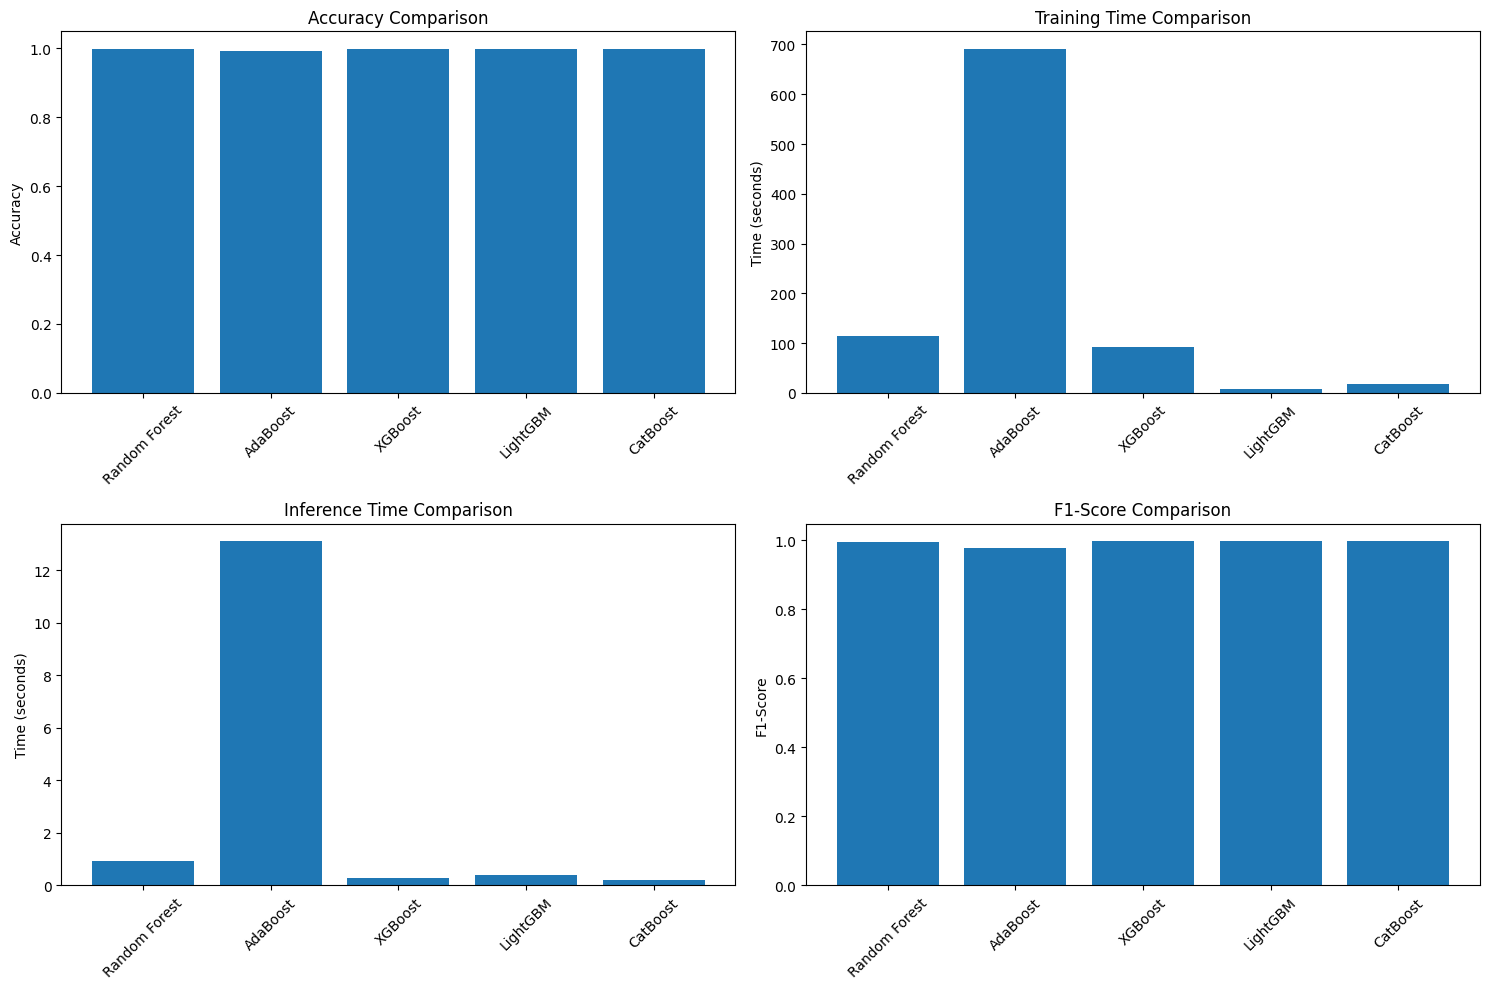

In [8]:

# ============================================================================
# CELL 7: Display Results for Binary Classification (CIC-IDS2017)
# ============================================================================
"""
Display and visualize results
"""

best_model, results_df = ids_binary.display_results()
ids_binary.plot_results(results_df)


In [9]:


# ============================================================================
# CELL 8: Extract Rules from Best Model (CIC-IDS2017 Binary)
# ============================================================================
"""
Extract interpretable rules for explainability
"""

rules = ids_binary.extract_rules(model_name='XGBoost', max_rules=10)




Extracting Rules from XGBoost

Top 10 Important Features:
  Bwd Packet Length Std: 0.4341
  Max Packet Length: 0.2293
  Average Packet Size: 0.1012
  Total Backward Packets: 0.0768
  Fwd Packet Length Std: 0.0211
  Init_Win_bytes_backward: 0.0141
  Active Std: 0.0129
  Total Fwd Packets: 0.0098
  PSH Flag Count: 0.0078
  Fwd Packet Length Max: 0.0062

Top 1 Rules (out of 1 total):

Rule 1:
  XGBoost model uses 77 features
  Class: Multiple
  Probability: 0.00%
  Samples: 1765653



In [10]:

# ============================================================================
# CELL 9: Save Model (CIC-IDS2017 Binary)
# ============================================================================
"""
Save the trained model for later use
"""

# Uncomment after training:
# ids_binary.save_model('ids_binary_cic2017.pkl')

print("Ready to save model. Uncomment the code above after training.")



Ready to save model. Uncomment the code above after training.


In [11]:

# ============================================================================
# CELL 10: EXPERIMENT 2 - CIC-IDS2017 Multi-class Classification
# ============================================================================
"""
Run multi-class classification on CIC-IDS2017 dataset
Detects: Benign + 14 different attack types
"""

# Use the same loaded dataset from binary classification
print("Using already loaded CIC2017 dataset for multiclass classification...")

# Initialize framework
ids_multiclass = IDSFramework(dataset_name='CIC-IDS2017')

# Load and prepare data
ids_multiclass.load_and_prepare_data(temp_file.name, task='multiclass')


Using already loaded CIC2017 dataset for multiclass classification...

Loading CIC-IDS2017 dataset...
Initial shape: (2830743, 79)
Duplicates found: 308381
Missing values found: 3128
After cleaning: (2522362, 78)
Training set: (1765653, 77)
Test set: (756709, 77)

Class distribution in training set:
0     1467539
4      120994
2       89611
10      63573
3        7200
7        4153
6        3770
5        3660
11       2253
1        1367
12       1029
14        456
9          25
13         15
8           8
Name: count, dtype: int64


In [12]:


# ============================================================================
# CELL 11: Train Models for Multi-class Classification (CIC-IDS2017)
# ============================================================================
"""
Train all 5 ensemble models on CIC-IDS2017 (Multi-class)
"""

ids_multiclass.initialize_models()
ids_multiclass.train_and_evaluate()



Initializing Ensemble Models...
Models initialized: ['Random Forest', 'AdaBoost', 'XGBoost', 'LightGBM', 'CatBoost']

Training and Evaluating Models...


Training Random Forest...
Random Forest - Accuracy: 0.9982, Train Time: 127.80s, Inference Time: 2.58s

Training AdaBoost...
AdaBoost - Accuracy: 0.9077, Train Time: 769.03s, Inference Time: 18.12s

Training XGBoost...
XGBoost - Accuracy: 0.9989, Train Time: 1001.04s, Inference Time: 1.97s

Training LightGBM...
LightGBM - Accuracy: 0.9214, Train Time: 52.93s, Inference Time: 4.25s

Training CatBoost...
CatBoost - Accuracy: 0.9961, Train Time: 427.76s, Inference Time: 0.39s



Results Summary - CIC-IDS2017

               accuracy  precision  recall  f1_score     mcc  auc_roc  train_time  inference_time     fpr     fnr
Random Forest    0.9982     0.9982  0.9982    0.9982  0.9941   0.9998    127.8010          2.5837  0.0004  0.1559
AdaBoost         0.9077     0.8773  0.9077    0.8833  0.6544   0.9595    769.0301         18.1226  0.0297  0.8386
XGBoost          0.9989     0.9989  0.9989    0.9989  0.9962   1.0000   1001.0428          1.9684  0.0002  0.0934
LightGBM         0.9214     0.9096  0.9214    0.9081  0.7096   0.8015     52.9308          4.2513  0.0265  0.8186
CatBoost         0.9961     0.9960  0.9961    0.9959  0.9870   0.9968    427.7608          0.3928  0.0008  0.2202

Best Model: XGBoost
Accuracy: 0.9989


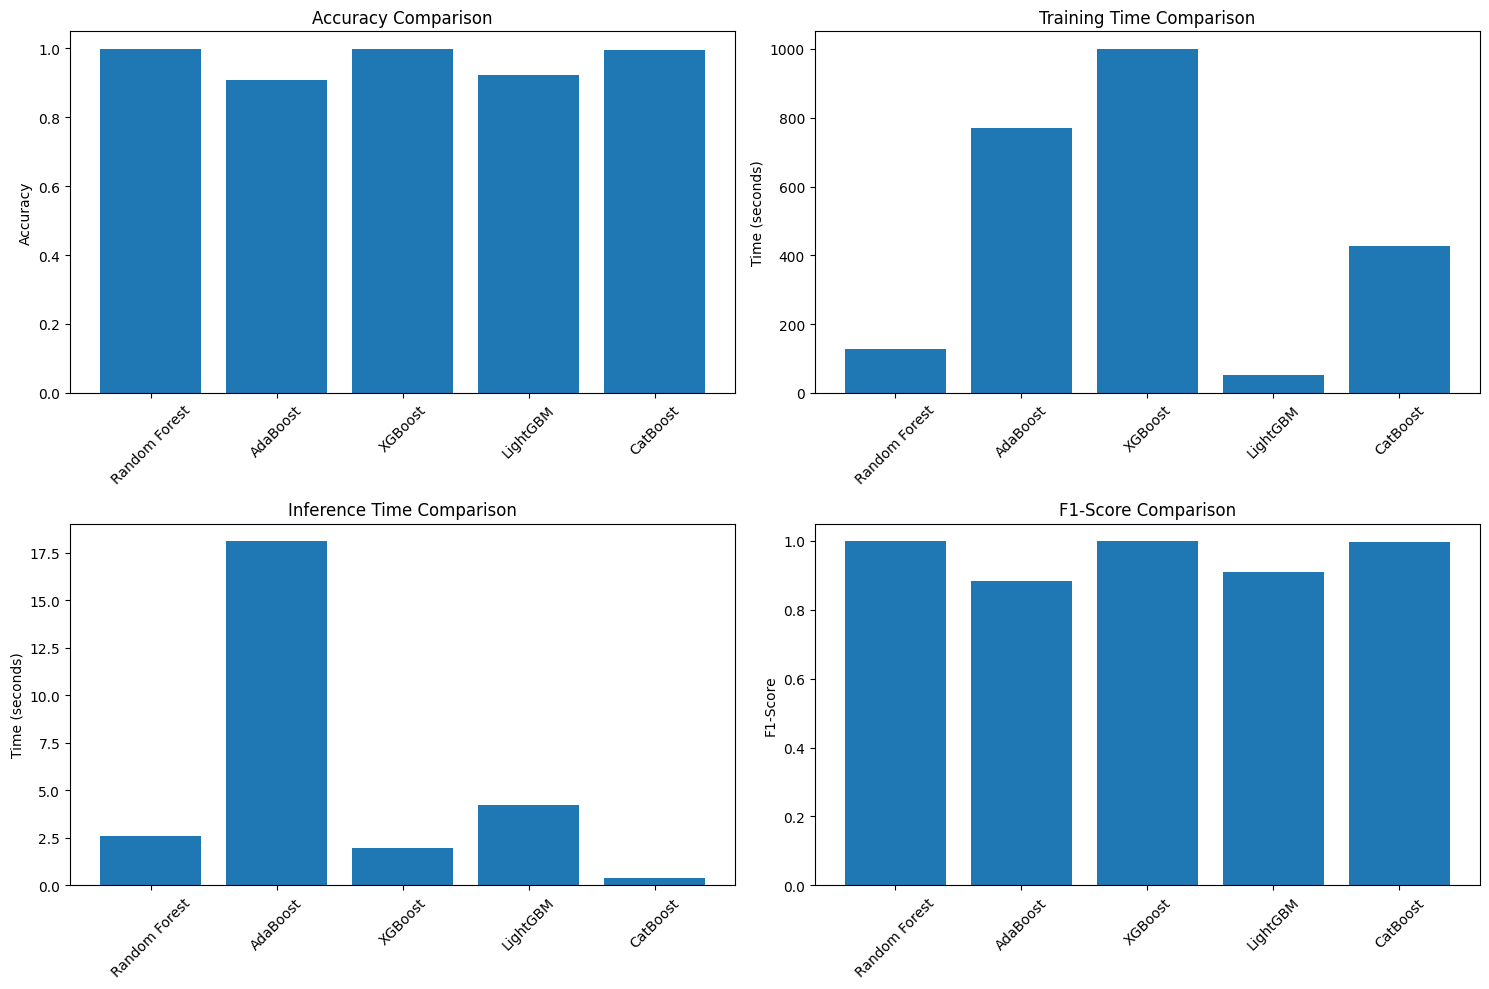

In [13]:


# ============================================================================
# CELL 12: Display Results for Multi-class Classification (CIC-IDS2017)
# ============================================================================
"""
Display and visualize results
"""

best_model_mc, results_df_mc = ids_multiclass.display_results()
ids_multiclass.plot_results(results_df_mc)


In [14]:


# ============================================================================
# CELL 13: Extract Rules from Best Model (CIC-IDS2017 Multi-class)
# ============================================================================
"""
Extract interpretable rules for multi-class classification
"""

rules_mc = ids_multiclass.extract_rules(model_name='XGBoost', max_rules=15)



Extracting Rules from XGBoost

Top 10 Important Features:
  Idle Mean: 0.2760
  Bwd Packet Length Std: 0.2074
  act_data_pkt_fwd: 0.0992
  Bwd Packet Length Mean: 0.0685
  Max Packet Length: 0.0568
  Total Backward Packets: 0.0548
  Average Packet Size: 0.0419
  Fwd Packet Length Max: 0.0308
  Total Length of Fwd Packets: 0.0261
  Total Length of Bwd Packets: 0.0218

Top 1 Rules (out of 1 total):

Rule 1:
  XGBoost model uses 77 features
  Class: Multiple
  Probability: 0.00%
  Samples: 1765653



In [15]:


# ============================================================================
# CELL 14: EXPERIMENT 3 - CICIoT2023 Binary Classification
# ============================================================================
"""
Run binary classification on CICIoT2023 dataset
Detects: Benign vs Attack
"""

# Load CIC2023 train dataset
print("Loading CIC2023 train dataset...")
df_2023_train = load_cic2023_dataset('train')

# Save to temporary CSV for the framework
import tempfile
temp_file_2023 = tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.csv')
df_2023_train.to_csv(temp_file_2023.name, index=False)
temp_file_2023.close()


# Initialize framework

ids_iot = IDSFramework(dataset_name='CICIoT2023')

ids_iot.load_and_prepare_data(temp_file_2023.name, task='binary')
# Load and prepare data

Loading CIC2023 train dataset...
Loading CIC2023 Dataset - TRAIN Split
Loading train.csv (1548.24 MB)... ✓

Rows: 5,491,971
Columns: 47
Target column: 'label'
Unique labels: 34

Label distribution:
label
DDoS-ICMP_Flood            848088
DDoS-UDP_Flood             637558
DDoS-TCP_Flood             528499
DDoS-PSHACK_Flood          481254
DDoS-SYN_Flood             478653
DDoS-RSTFINFlood           475441
DDoS-SynonymousIP_Flood    422083
DoS-UDP_Flood              390422
DoS-TCP_Flood              314174
DoS-SYN_Flood              237573
BenignTraffic              129538
Mirai-greeth_flood         116133
Mirai-udpplain             104814
Mirai-greip_flood           88821
DDoS-ICMP_Fragmentation     53046
MITM-ArpSpoofing            36316
DDoS-UDP_Fragmentation      34169
DDoS-ACK_Fragmentation      33581
DNS_Spoofing                21214
Recon-HostDiscovery         15737
Recon-OSScan                11587
Recon-PortScan               9648
DoS-HTTP_Flood               8487
VulnerabilityS

In [16]:

# ============================================================================
# CELL 15: Train Models for Binary Classification (CICIoT2023)
# ============================================================================
"""
Train all 5 ensemble models on CICIoT2023 (Binary)
"""

ids_iot.initialize_models()
ids_iot.train_and_evaluate()




Initializing Ensemble Models...
Models initialized: ['Random Forest', 'AdaBoost', 'XGBoost', 'LightGBM', 'CatBoost']

Training and Evaluating Models...


Training Random Forest...
Random Forest - Accuracy: 0.9975, Train Time: 98.91s, Inference Time: 1.35s

Training AdaBoost...
AdaBoost - Accuracy: 0.9952, Train Time: 727.26s, Inference Time: 18.73s

Training XGBoost...
XGBoost - Accuracy: 0.9975, Train Time: 143.39s, Inference Time: 0.41s

Training LightGBM...
LightGBM - Accuracy: 0.9964, Train Time: 6.76s, Inference Time: 0.63s

Training CatBoost...
CatBoost - Accuracy: 0.9961, Train Time: 26.94s, Inference Time: 0.40s



Results Summary - CICIoT2023

               accuracy  precision  recall  f1_score     mcc  auc_roc  train_time  inference_time     fpr     fnr
Random Forest    0.9975     0.9991  0.9984    0.9987  0.9475   0.9997     98.9108          1.3537  0.0388  0.0016
AdaBoost         0.9952     0.9983  0.9967    0.9975  0.8991   0.9993    727.2614         18.7255  0.0684  0.0033
XGBoost          0.9975     0.9992  0.9983    0.9987  0.9471   0.9998    143.3910          0.4082  0.0349  0.0017
LightGBM         0.9964     0.9988  0.9975    0.9982  0.9242   0.9995      6.7586          0.6320  0.0496  0.0025
CatBoost         0.9961     0.9986  0.9975    0.9980  0.9184   0.9994     26.9389          0.4045  0.0594  0.0025

Best Model: Random Forest
Accuracy: 0.9975


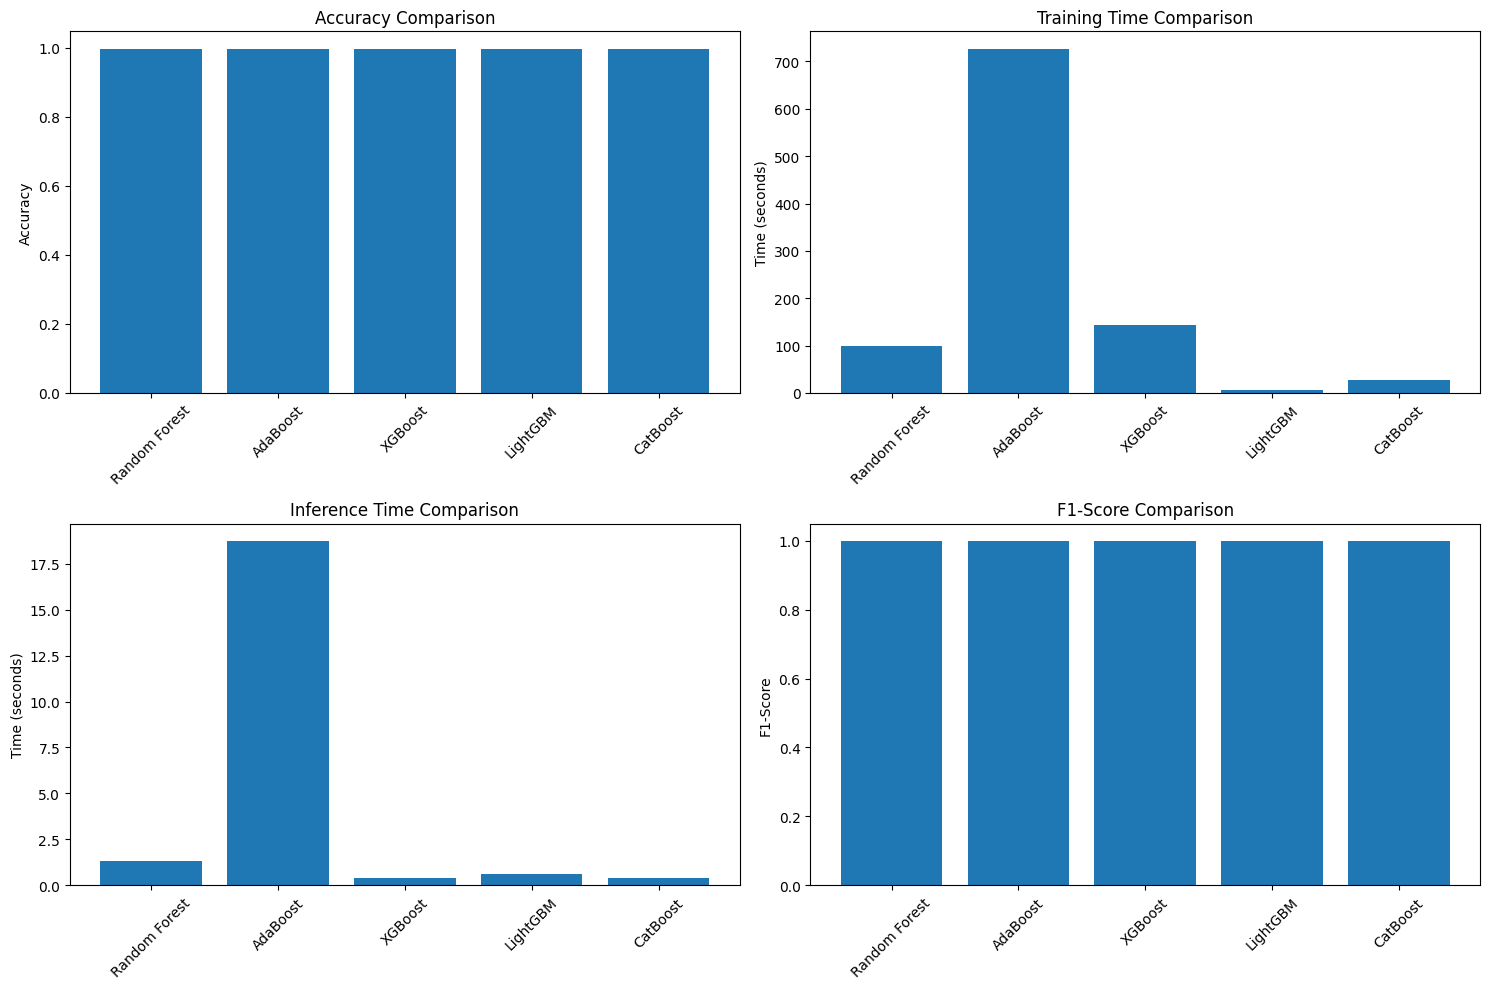

In [17]:

# ============================================================================
# CELL 16: Display Results for Binary Classification (CICIoT2023)
# ============================================================================
"""
Display and visualize results
"""

best_model_iot, results_df_iot = ids_iot.display_results()
ids_iot.plot_results(results_df_iot)



In [18]:

# ============================================================================
# CELL 17: Extract Rules from Best Model (CICIoT2023 Binary)
# ============================================================================
"""
Extract interpretable rules for explainability
"""

rules_iot = ids_iot.extract_rules(model_name='XGBoost', max_rules=10)




Extracting Rules from XGBoost

Top 10 Important Features:
  rst_count: 0.4094
  urg_count: 0.1381
  Number: 0.1379
  IAT: 0.1180
  HTTP: 0.0265
  HTTPS: 0.0265
  psh_flag_number: 0.0156
  flow_duration: 0.0136
  fin_count: 0.0133
  Rate: 0.0128

Top 1 Rules (out of 1 total):

Rule 1:
  XGBoost model uses 46 features
  Class: Multiple
  Probability: 0.00%
  Samples: 3750184



In [19]:

# ============================================================================
# CELL 18: Compare All Experiments
# ============================================================================
"""
Compare results across all experiments
"""

def compare_experiments(results_dict):
    """Compare multiple experiment results"""
    
    comparison_data = []
    
    for exp_name, results_df in results_dict.items():
        best_model = results_df['accuracy'].idxmax()
        comparison_data.append({
            'Experiment': exp_name,
            'Best Model': best_model,
            'Accuracy': results_df.loc[best_model, 'accuracy'],
            'Precision': results_df.loc[best_model, 'precision'],
            'Recall': results_df.loc[best_model, 'recall'],
            'F1-Score': results_df.loc[best_model, 'f1_score'],
            'AUC-ROC': results_df.loc[best_model, 'auc_roc'],
            'Train Time': results_df.loc[best_model, 'train_time'],
            'Inference Time': results_df.loc[best_model, 'inference_time']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("COMPARISON OF ALL EXPERIMENTS")
    print("="*80)
    print(comparison_df.to_string(index=False))
    
    return comparison_df

results_dict = {
    'CIC-IDS2017 Binary': results_df,
    'CIC-IDS2017 Multi-class': results_df_mc,
    'CICIoT2023 Binary': results_df_iot
}
comparison_df = compare_experiments(results_dict)



COMPARISON OF ALL EXPERIMENTS
             Experiment    Best Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC  Train Time  Inference Time
     CIC-IDS2017 Binary       XGBoost    0.9992     0.9965  0.9988    0.9976   1.0000     93.1360          0.2688
CIC-IDS2017 Multi-class       XGBoost    0.9989     0.9989  0.9989    0.9989   1.0000   1001.0428          1.9684
      CICIoT2023 Binary Random Forest    0.9975     0.9991  0.9984    0.9987   0.9997     98.9108          1.3537


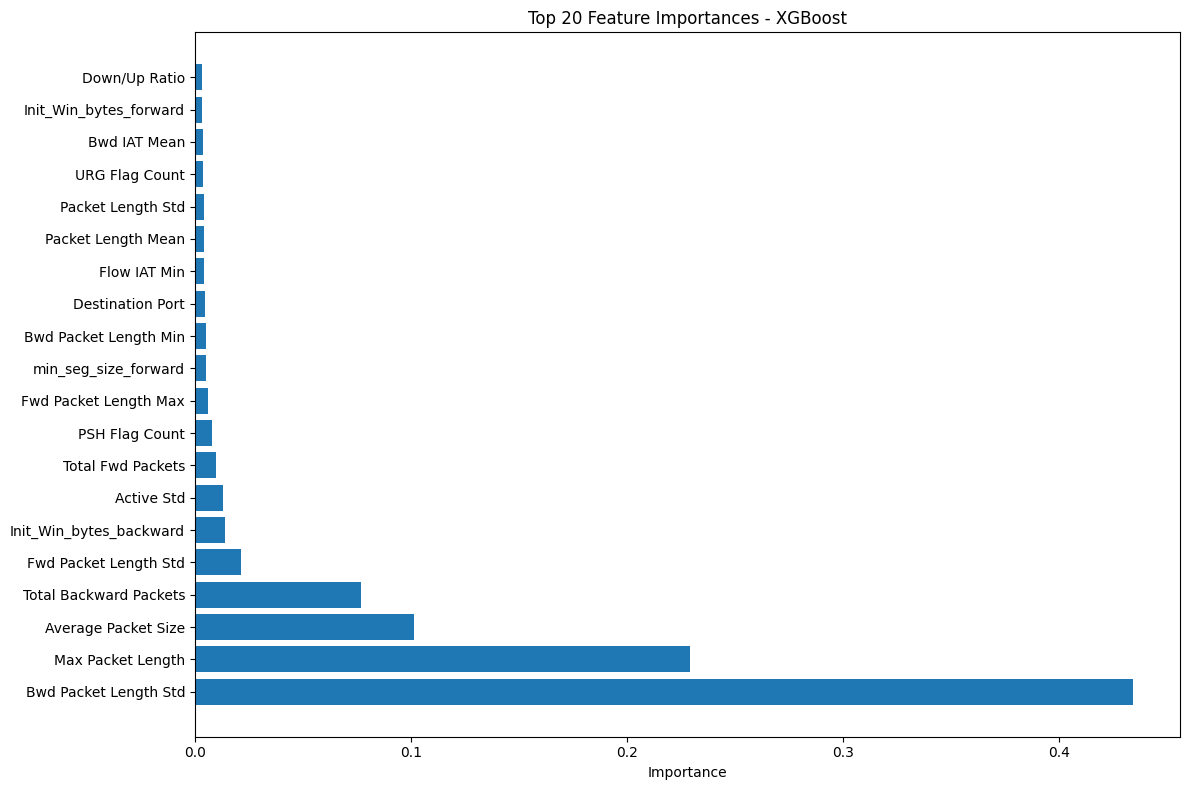


Top 20 Features:
1. Bwd Packet Length Std: 0.4341
2. Max Packet Length: 0.2293
3. Average Packet Size: 0.1012
4. Total Backward Packets: 0.0768
5. Fwd Packet Length Std: 0.0211
6. Init_Win_bytes_backward: 0.0141
7. Active Std: 0.0129
8. Total Fwd Packets: 0.0098
9. PSH Flag Count: 0.0078
10. Fwd Packet Length Max: 0.0062
11. min_seg_size_forward: 0.0053
12. Bwd Packet Length Min: 0.0051
13. Destination Port: 0.0045
14. Flow IAT Min: 0.0042
15. Packet Length Mean: 0.0042
16. Packet Length Std: 0.0040
17. URG Flag Count: 0.0037
18. Bwd IAT Mean: 0.0036
19. Init_Win_bytes_forward: 0.0033
20. Down/Up Ratio: 0.0031


In [20]:
# ============================================================================
# CELL 19: Feature Importance Analysis
# ============================================================================
"""
Analyze feature importance from the best models
"""

def plot_feature_importance(ids_framework, model_name='XGBoost', top_n=20):
    """Plot top N important features"""
    
    model = ids_framework.models[model_name]
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = ids_framework.feature_names
        
        # Get top N features
        indices = np.argsort(importances)[-top_n:][::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Top {top_n} Feature Importances - {model_name}')
        plt.barh(range(top_n), importances[indices])
        plt.yticks(range(top_n), [feature_names[i] for i in indices])
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        
        # Print feature importances
        print(f"\nTop {top_n} Features:")
        for i, idx in enumerate(indices, 1):
            print(f"{i}. {feature_names[idx]}: {importances[idx]:.4f}")
    else:
        print(f"{model_name} does not have feature_importances_ attribute")

plot_feature_importance(ids_binary, model_name='XGBoost', top_n=20)


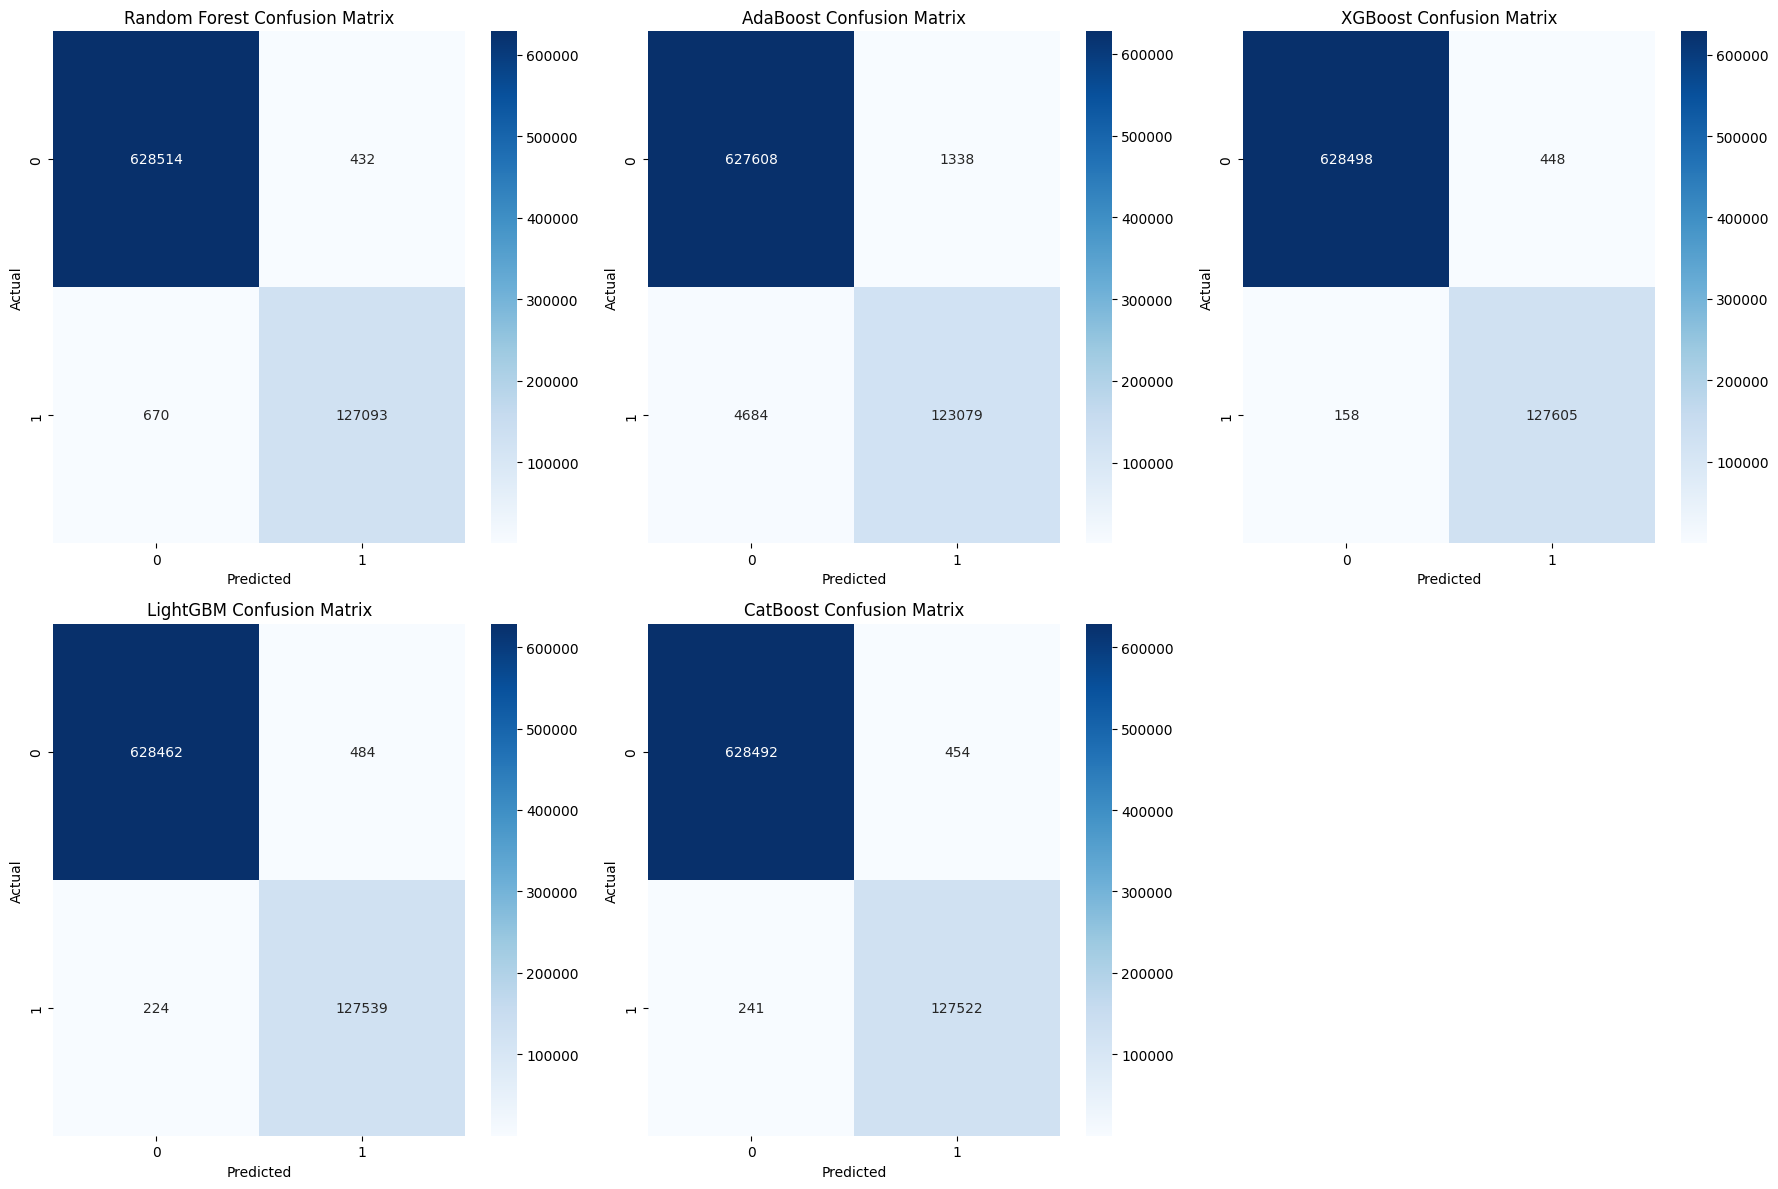

In [22]:
# ============================================================================
# CELL 20: Confusion Matrix Visualization
# ============================================================================
"""
Visualize confusion matrices for all models
"""

def plot_confusion_matrices(ids_framework):
    """Plot confusion matrices for all models"""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for idx, (name, model) in enumerate(ids_framework.models.items()):
        y_pred = model.predict(ids_framework.X_test)
        cm = confusion_matrix(ids_framework.y_test, y_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
        axes[idx].set_title(f'{name} Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')
    
    # Hide the extra subplot
    axes[5].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for binary classification
plot_confusion_matrices(ids_binary)